In [1]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!cd '/content/drive/My Drive/Colab Notebooks/dl/data' 

In [9]:
!pip install kmodes

# Group 1 "We know them!" - User Journeys Cluster - Analysis

In [3]:
import numpy as np
import pandas as pd
import pickle as pkl
from tabulate import tabulate
import os
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorboard.plugins import projector
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from datetime import datetime
from kmodes.kprototypes import KPrototypes
from joblib import dump, load

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [6]:
def plot_dists(column, bins, xlim):
    fig = plt.figure(tight_layout=True, figsize=(10,4), dpi=108)
    plt.xlim(0,xlim)
    t=str(column+" Distribution")
    plt.suptitle(t, fontsize=14, fontweight='bold')
    sns.distplot(C0[column],bins, label='C0')
    sns.distplot(C1[column],bins, label='C1')
    sns.distplot(C2[column],bins, label='C2')
    sns.distplot(C3[column],bins, label='C3')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
def Load_Dicts(pkl_filename):
  All_Dicts = pkl.load( open (pkl_filename, "rb"))
  Dict_Opt= All_Dicts[0]
  Events_Dict= All_Dicts[1]
  Education_Dict= All_Dicts[2]
  Jobs_Dict= All_Dicts[3]
  Countries_Dict = All_Dicts[4]
  Companies_Dict = All_Dicts[5]
  First_Pages_Dict = All_Dicts[6]
  Last_Pages_Dict = All_Dicts[7]
  Courses_Dict= All_Dicts[8]
  return Dict_Opt, Events_Dict, Education_Dict, Jobs_Dict, Countries_Dict, Companies_Dict, First_Pages_Dict, Last_Pages_Dict, Courses_Dict

def Inv_Dict(dct):
    inv_map = {v: k for k, v in dct.items()}
    return inv_map

def Top(dct,ntop,arg):
    top=[]
    for i in range(0,ntop+1):
        top.append(dct[arg[i]])
    return top

def Top_Clusters(column, dct, topn=2):
    C0_top = C0.groupby(C0[column])[column].count().to_numpy()
    arg = np.flip(C0_top.argsort())
    C0_top_names = Top(dct,topn,arg)
    C1_top = C1.groupby(C1[column])[column].count().to_numpy()
    arg = np.flip(C1_top.argsort())
    C1_top_names = Top(dct,topn,arg)
    C2_top = C2.groupby(C2[column])[column].count().to_numpy()
    arg = np.flip(C2_top.argsort())
    C2_top_names = Top(dct,topn,arg)
    C3_top = C3.groupby(C3[column])[column].count().to_numpy()
    arg = np.flip(C3_top.argsort())
    C3_top_names = Top(dct,topn,arg)
    return C0_top, C0_top_names, C1_top, C1_top_names,C2_top, C2_top_names, C3_top, C3_top_names

def Plot_Pie(title,ncluster, C_top, C_top_names, topn, myexplode):
    fig = plt.figure(tight_layout=True, figsize=(10,4), dpi=108)
    t = "Cluster "+ str(ncluster)+ " - "+ title
    names = [c.title() for c in C_top_names]
    names.insert(len(names),'Others')
    data = C_top[0:topn+2]
    data[topn+1] = np.sum(data[topn+1:])
    plt.suptitle(t, fontsize=12, fontweight='bold')
    plt.pie(data, labels=names, startangle = 90, autopct='%1.2f%%', explode=myexplode, shadow=True, textprops={'fontsize': 10})
    plt.show()
            

In [7]:
binary_columns = ['Opted out of email: Events and Community', 'Opted out of email: Program Announcements', 'Opted out of email: The Batch', 'Unsubscribed from all email', 'AI For Everyone', 'Deep Learning Specialization', 'Natural Language Processing Specialization', 'AI for Medicine Specialization', 'TensorFlow Developer Professional Certificate','TensorFlow: Data and Deployment Specialization']
numeric_columns = ['Number of Pageviews','Average Pageviews','Number of Sessions','Marketing emails opened', 'Marketing emails delivered','Marketing emails clicked', 'Total Education Effort','Longevity']
timestamp_columns = ['Became a Lead Date', 'Became a Subscriber Date', 'First Conversion Date', 'First marketing email click date', 'First marketing email open date', 'First marketing email send date', 'Last marketing email click date', 'Last marketing email open date', 'Last marketing email send date','Last Registered Event Date']
categorical_columns = ['First Page Seen Path', 'Last Page Seen Path', 'Last Registered Event','Last marketing email name','Highest level of completed education', 'Job Title or Function', 'IP Country', 'Associated Company ID']

## 1. User Journey Identification and Analysis - Group 1

In [10]:
df_base = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/dl/data/converted_students_clustering_data_01282021.pkl")

In [11]:
Dict_Opt, Events_Dict, Education_Dict, Jobs_Dict, Countries_Dict, Companies_Dict, First_Pages_Dict, Last_Pages_Dict, Courses_Dict= Load_Dicts("/content/drive/My Drive/Colab Notebooks/dl/data/all_dictionaries.pkl")
kproto = load("/content/drive/My Drive/Colab Notebooks/dl/data/converted_students_cluster_model.joblib")

In [12]:
C_vals = df_base['Cluster'].values

In [13]:
X_train = df_base.drop(columns=['Cluster']).copy()

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [15]:
pca = PCA(n_components=3)
X_red = pca.fit_transform(X_train, C_vals)

In [37]:
PATH = os.getcwd()
LOG_DIR = PATH + '/project-tensorboard/log-1'

In [38]:
def register_embedding(embedding_tensor_name, meta_data_fname, log_dir):
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_tensor_name
    embedding.metadata_path = meta_data_fname
    projector.visualize_embeddings(log_dir, config)

def save_labels_tsv(labels, filepath, log_dir):
    with open(os.path.join(log_dir, filepath), 'w') as f:
        for label in labels:
            f.write('{}\n'.format(label))

In [ ]:
LOG_DIR = './data/project-tensorboard/log-1'
META_DATA_FNAME = 'meta_cos_reduction1.tsv'  # Labels will be stored here
EMBEDDINGS_TENSOR_NAME = 'sample_data_cos_reduction1'
EMBEDDINGS_FPATH = os.path.join(LOG_DIR, EMBEDDINGS_TENSOR_NAME + '.ckpt')
STEP = 0

register_embedding(EMBEDDINGS_TENSOR_NAME, META_DATA_FNAME, LOG_DIR)
save_labels_tsv(C_vals, META_DATA_FNAME, LOG_DIR)#version 1

In [ ]:
tf.compat.v1.disable_eager_execution()
tensor_embeddings = tf.Variable(X_train, name=EMBEDDINGS_TENSOR_NAME)
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())
saver = tf.compat.v1.train.Saver()
saver.save(sess, EMBEDDINGS_FPATH, STEP)
sess.close()

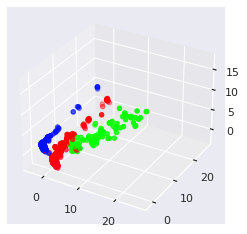

In [ ]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(X_red[:,0], X_red[:,1], X_red[:,2], c=C_vals, cmap='hsv');
plt.show()

In [16]:
group1_cluster_sizes = df_base.groupby(df_base['Cluster'])['Cluster'].count()
group1_cluster_perc = round(group1_cluster_sizes/df_base.shape[0],2)

+-----------+--------------+------------+
| Cluster # | Cluster Size | % of Total |
+-----------+--------------+------------+
|     0     |     7989     |    61.0    |
|     1     |     133      |    1.0     |
|     2     |     2917     |    22.0    |
|     3     |     2145     |    16.0    |
+-----------+--------------+------------+


<AxesSubplot:ylabel='Cluster'>

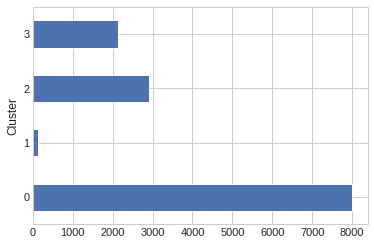

In [ ]:
prt_list=[]
for k in range(0,4):
  prt_list.append((k, group1_cluster_sizes[k], 100*round(group1_cluster_sizes[k]/df_base.shape[0],2)))
print(tabulate(prt_list,headers=["Cluster #", "Cluster Size", "% of Total"],tablefmt="pretty"))
group1_cluster_sizes.plot(kind='barh')

In [17]:
C0 = df_base[df_base['Cluster']==0]

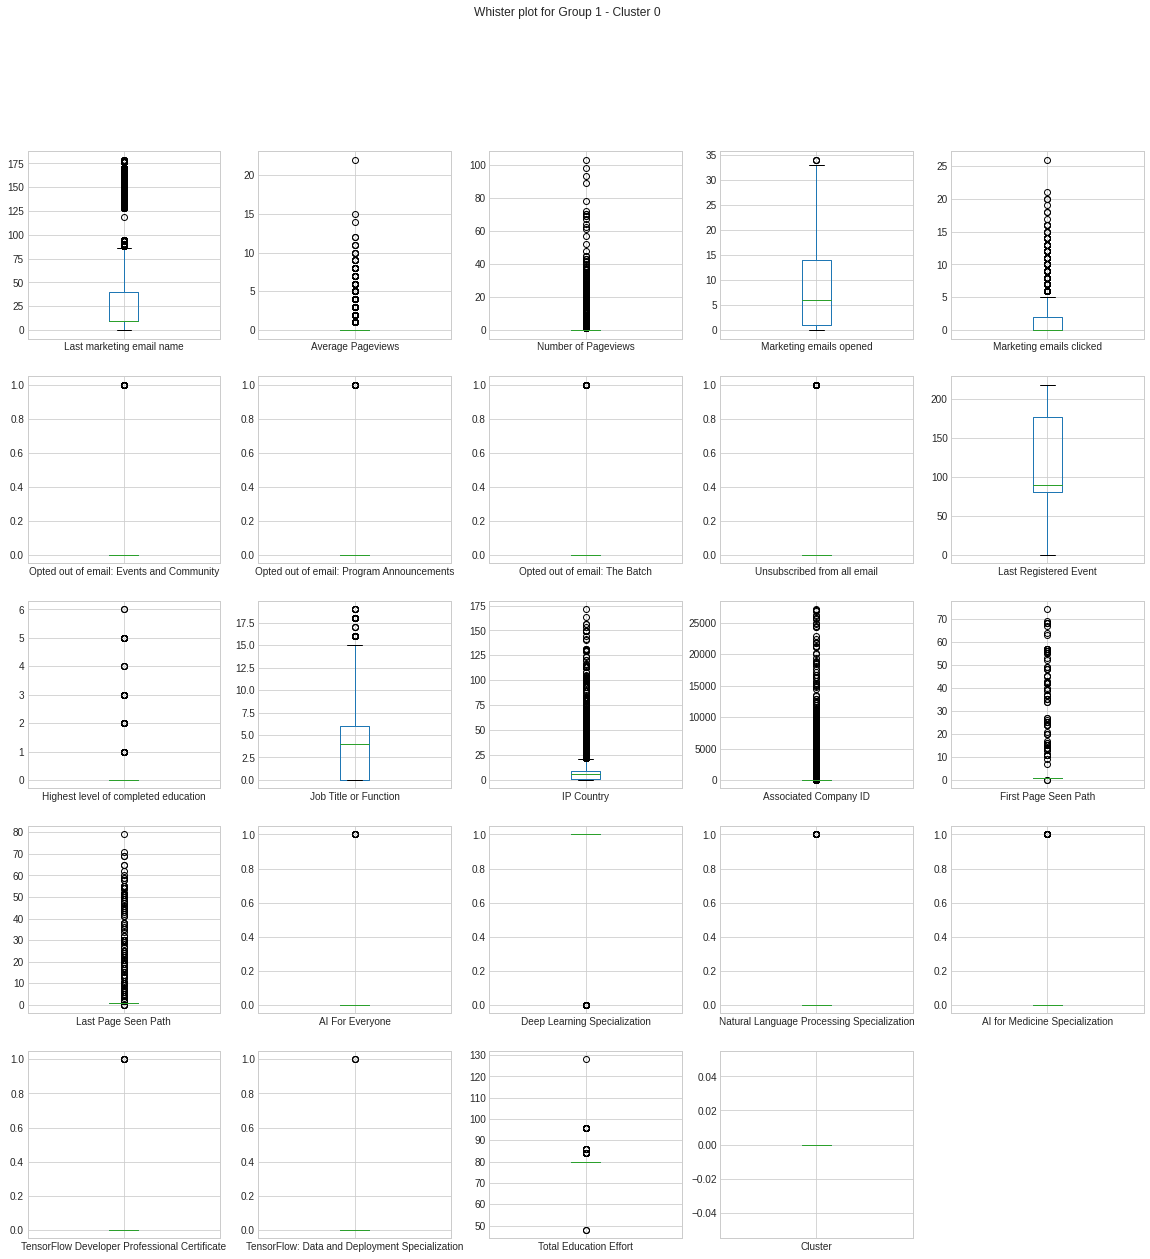

In [18]:
# Whiskerplots
c = 'black'
C0.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(20,20),
                                        title='Whister plot for Group 1 - Cluster 0')
plt.savefig('Group 1 - Cluster 0')
plt.show()

In [ ]:
C0['Number of Pageviews'].describe()

count    7989.000000
mean        1.527475
std         5.377013
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       103.000000
Name: Number of Pageviews, dtype: float64

In [19]:
C1 = df_base[df_base['Cluster']==1]

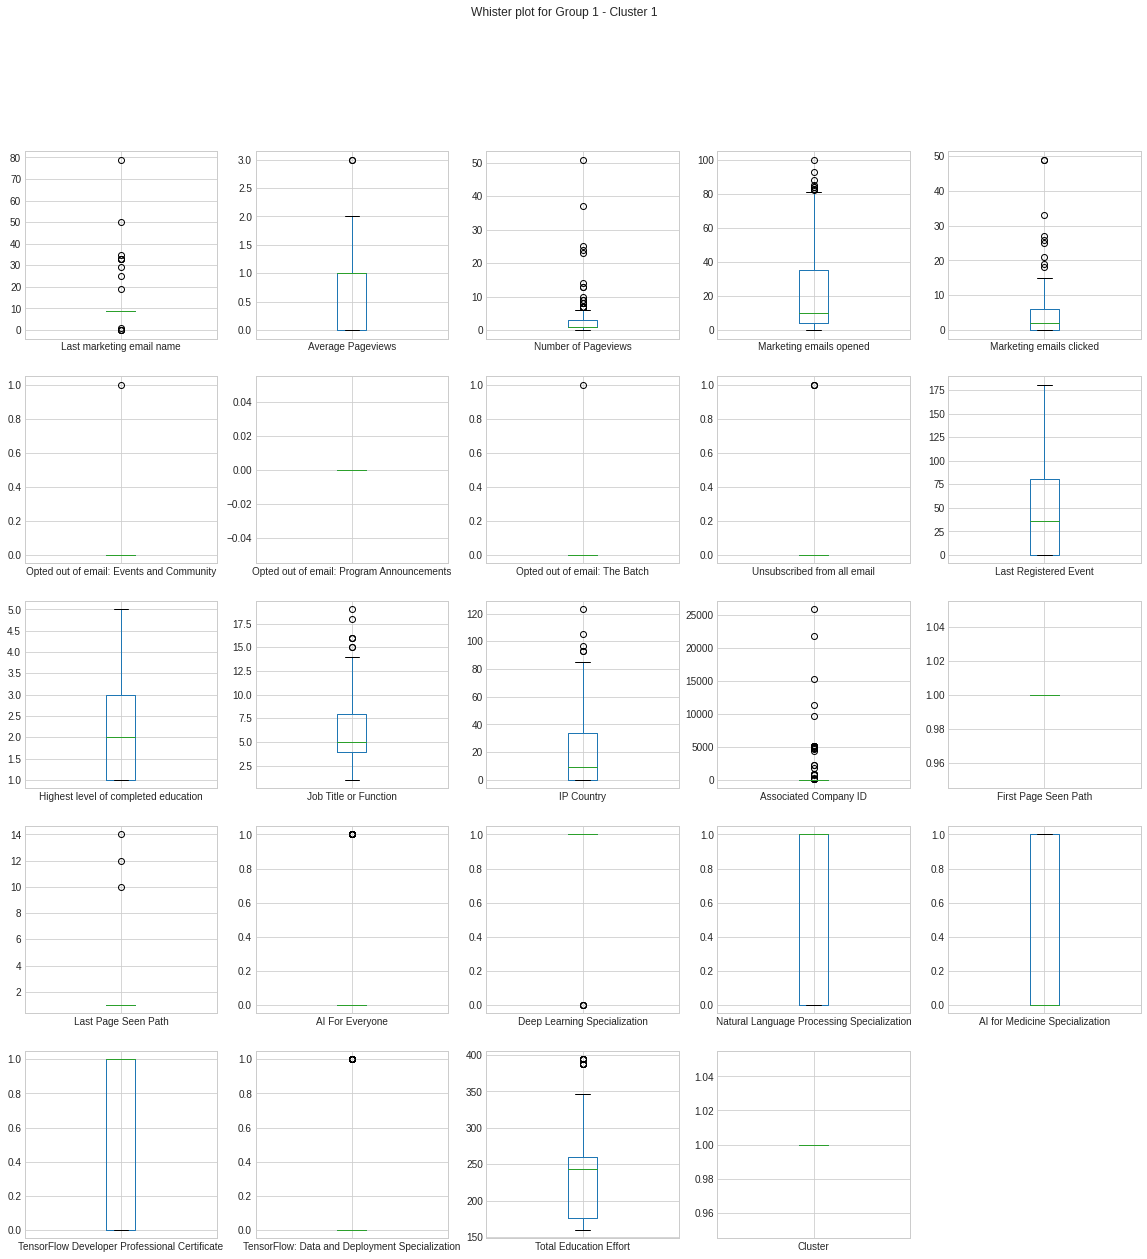

In [20]:
# Whiskerplots
c = 'black'
C1.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(20,20),
                                        title='Whister plot for Group 1 - Cluster 1')
plt.savefig('Group 1 - Cluster 0')
plt.show()

In [21]:
C2 = df_base[df_base['Cluster']==2]

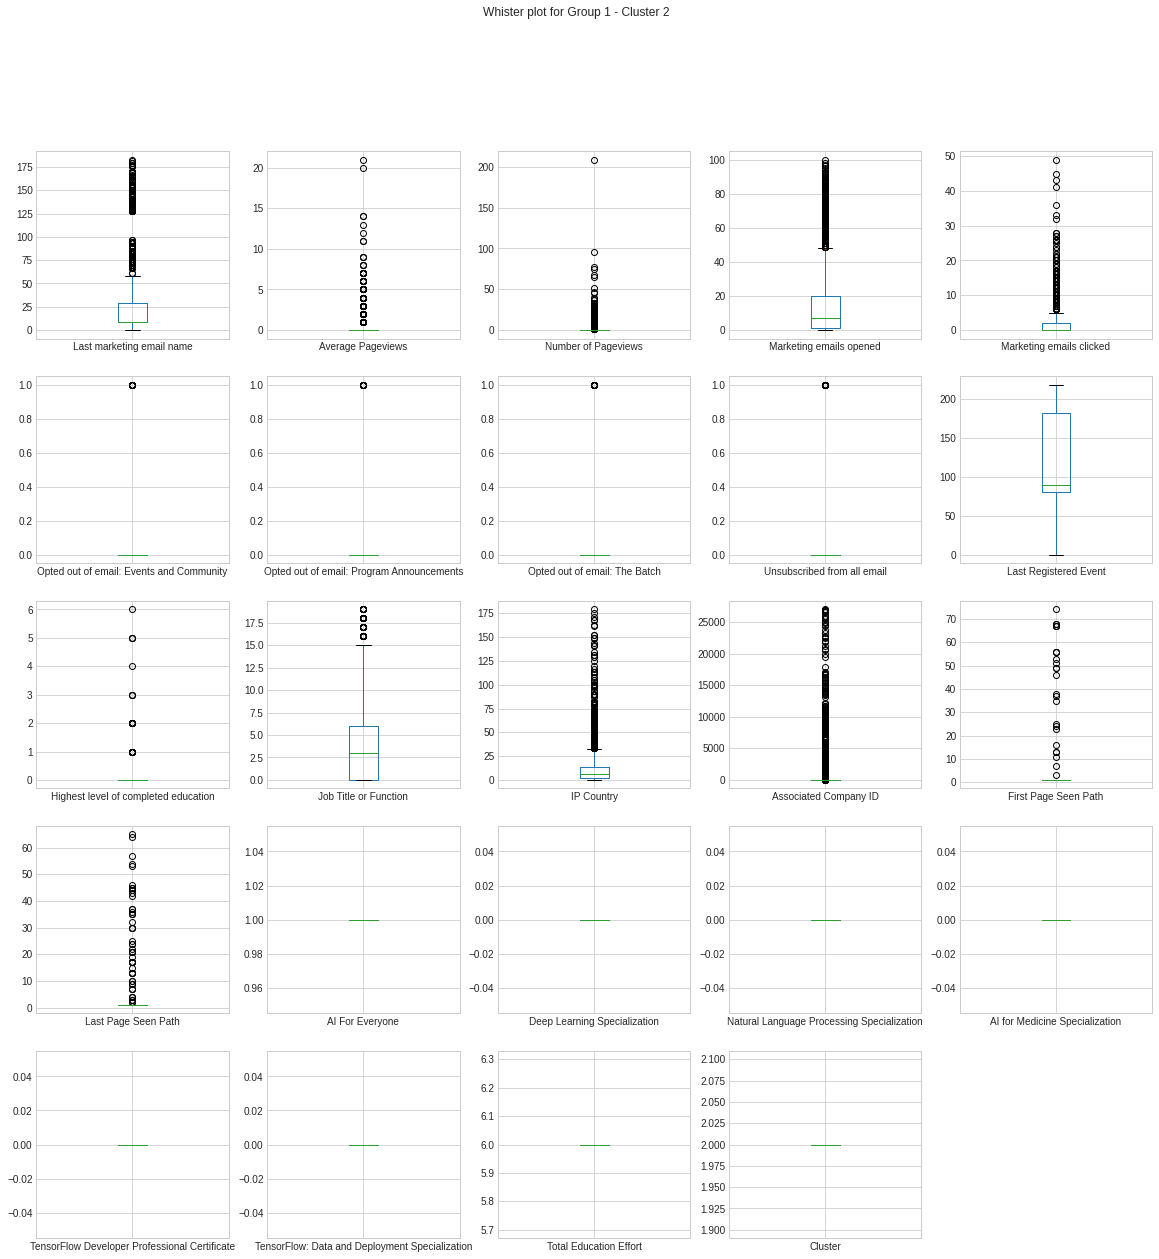

In [22]:
# Whiskerplots
c = 'black'
C2.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(20,20),
                                        title='Whister plot for Group 1 - Cluster 2')
plt.savefig('Group 1 - Cluster 0')
plt.show()

In [23]:
C3 = df_base[df_base['Cluster']==3]

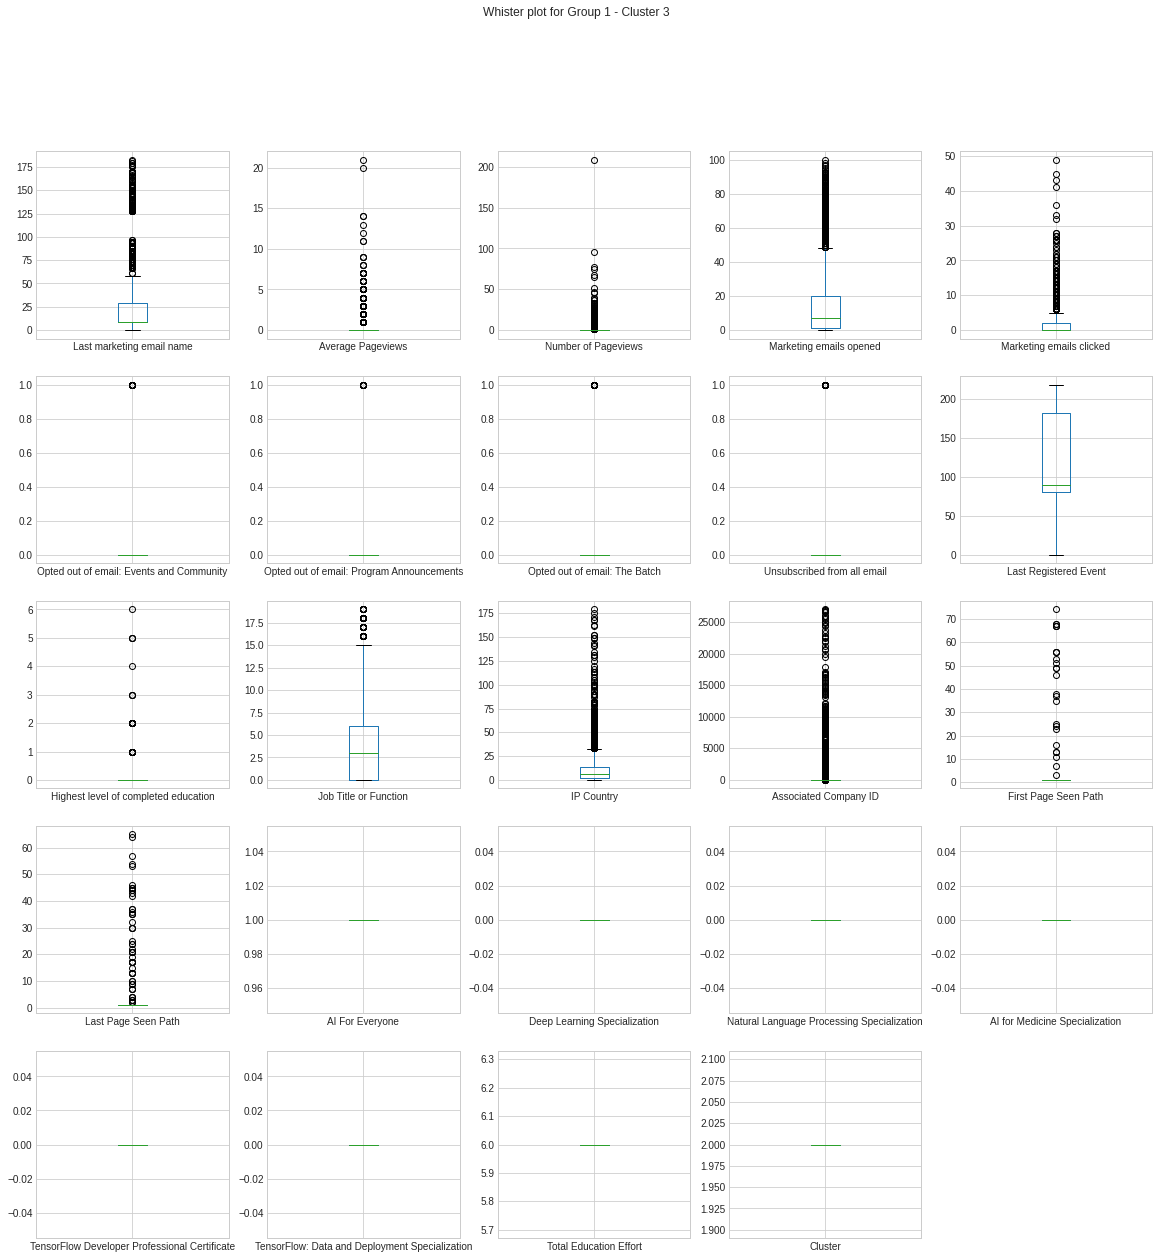

In [24]:
# Whiskerplots
c = 'black'
C2.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(20,20),
                                        title='Whister plot for Group 1 - Cluster 3')
plt.savefig('Group 1 - Cluster 0')
plt.show()

In [25]:
C1['Total Education Effort'].describe()

count    133.000000
mean     235.909774
std       71.172375
min      160.000000
25%      176.000000
50%      244.000000
75%      260.000000
max      394.000000
Name: Total Education Effort, dtype: float64

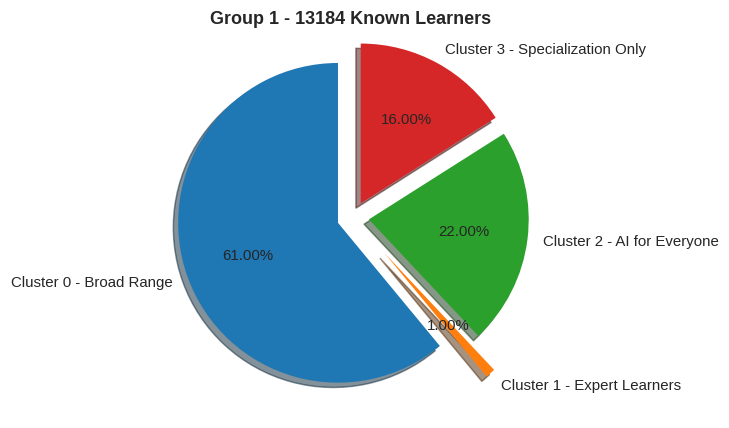

In [26]:
gc = round(100*group1_cluster_perc,2)
fig = plt.figure(tight_layout=True, figsize=(10,4), dpi=108)
t = "Group 1 - "+ str(df_base.shape[0])+ " Known Learners "
names = ["Cluster 0 - Broad Range",
          "Cluster 1 - Expert Learners",
          "Cluster 2 - AI for Everyone",
          "Cluster 3 - Specialization Only"]

data = gc
myexplode = [0.1, 0.3, 0.1, 0.1]
plt.suptitle(t, fontsize=12, fontweight='bold')
plt.pie(gc, labels=names, startangle = 90, autopct='%1.2f%%', explode=myexplode, shadow=True)
plt.show() 


In [27]:
plt.style.use('seaborn-whitegrid')

In [ ]:
G1_countries = df_base.groupby(df_base['IP Country'])['IP Country'].count()
arg = np.flip(G1_countries.argsort().to_numpy())
G1_top_countries = Top(Countries_Dict,2,arg)
fig = plt.figure(tight_layout=True, figsize=(10,4), dpi=108)
t = "Group 1 - Top Countries of Origin "
names = [c.title() for c in G1_top_countries]
data = G1_countries[0:3]
myexplode = [0, 0.1, 0.3]
plt.suptitle(t, fontsize=12, fontweight='bold')
plt.pie(data, labels=names, startangle = 90, autopct='%1.2f%%', explode=myexplode, shadow=True, textprops={'fontsize': 10})
plt.show() 

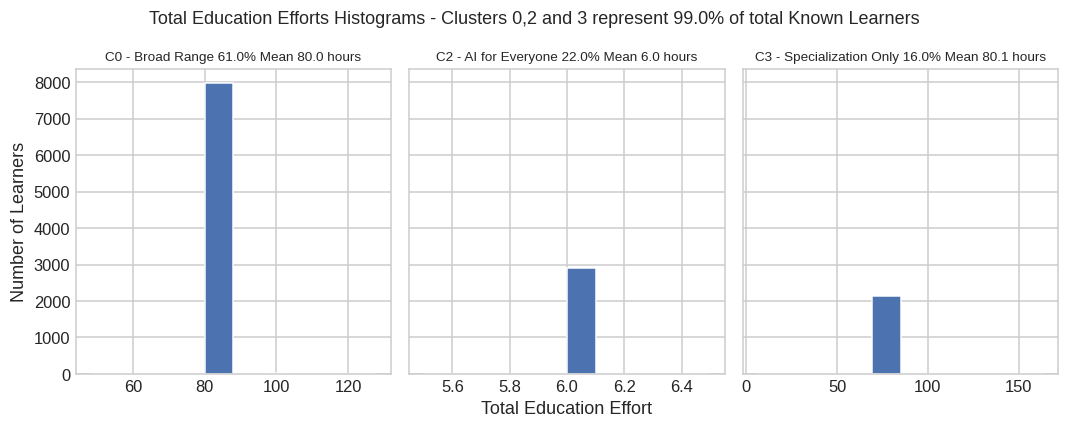

In [ ]:
n_bins=10
t="Total Education Efforts Histograms - Clusters 0,2 and 3 represent "+str(round(100*(1-group1_cluster_perc[1]),2))+"% of total Known Learners"
t0="C0 - Broad Range "+str(100* group1_cluster_perc[0])+"% Mean "+str(round(C0['Total Education Effort'].mean(),1))+ " hours"
t1="C2 - AI for Everyone "+str(100* group1_cluster_perc[2])+"% Mean "+str(round(C2['Total Education Effort'].mean(),1))+ " hours"
t2="C3 - Specialization Only "+str(100* group1_cluster_perc[3])+"% Mean "+str(round(C3['Total Education Effort'].mean(),1))+ " hours"
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True,figsize=(10,4), dpi=108)
fig.suptitle(t, fontsize=12)
axs[0].hist(C0['Total Education Effort'].values, bins=n_bins)
axs[1].hist(C2['Total Education Effort'].values, bins=n_bins)
axs[2].hist(C3['Total Education Effort'].values, bins=n_bins)
axs[0].set_title(t0,fontsize=9)
axs[1].set_title(t1, fontsize=9)
axs[2].set_title(t2, fontsize=9)
axs[0].set_ylabel("Number of Learners")
axs[1].set_xlabel("Total Education Effort")
plt.show()

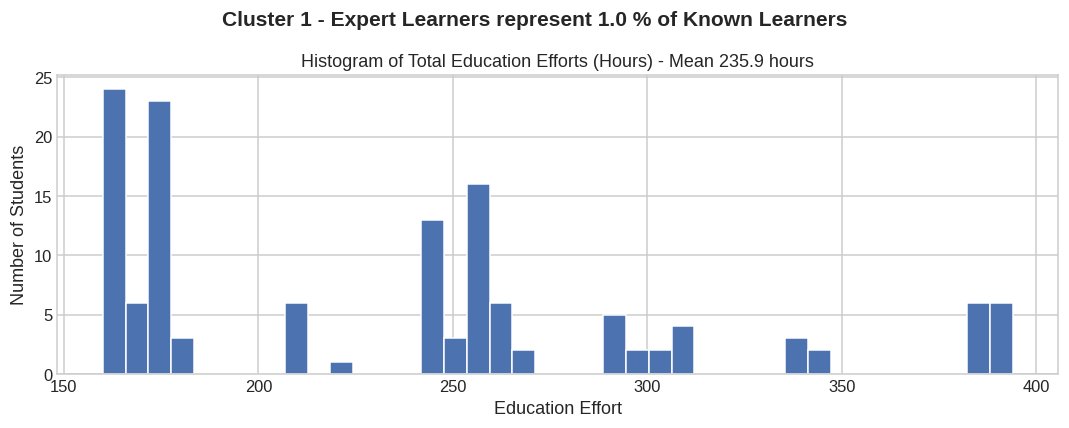

In [ ]:
fig = plt.figure(tight_layout=True, figsize=(10,4), dpi=108)
t="Cluster 1 - Expert Learners represent "+str(100*group1_cluster_perc[1])+" % of Known Learners"
h="Histogram of Total Education Efforts (Hours) - Mean "+str(round(C1['Total Education Effort'].mean(),1))+ " hours"
ax = plt.axes()
num_bins = 40
plt.suptitle(t, fontsize=14, fontweight='bold')
plt.hist(C1['Total Education Effort'].values, num_bins, density=False)
plt.title(h)
plt.xlabel("Education Effort")
plt.ylabel("Number of Students")
plt.tight_layout()
plt.show()

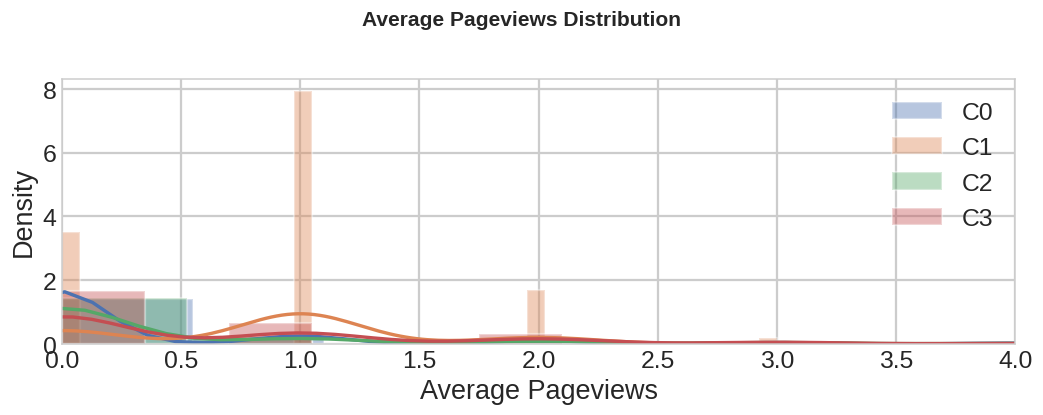

In [ ]:
plot_dists('Average Pageviews',bins=40,xlim=4)

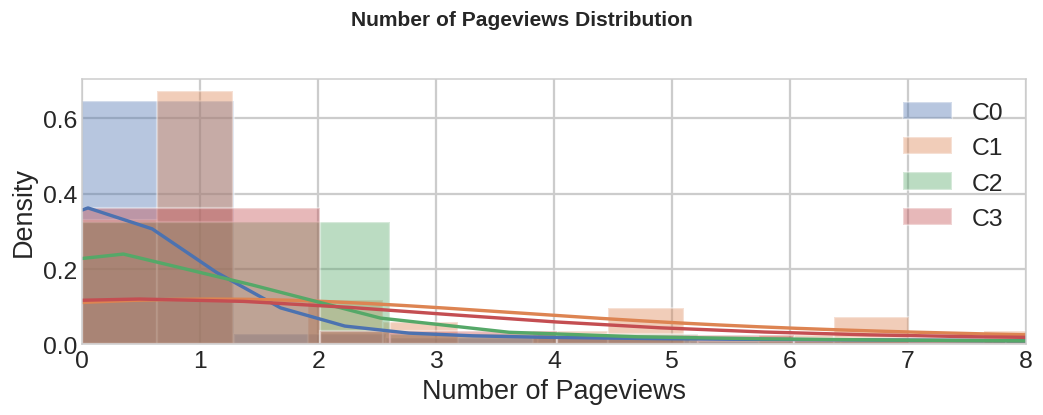

In [ ]:
plot_dists('Number of Pageviews',bins=80,xlim=8)

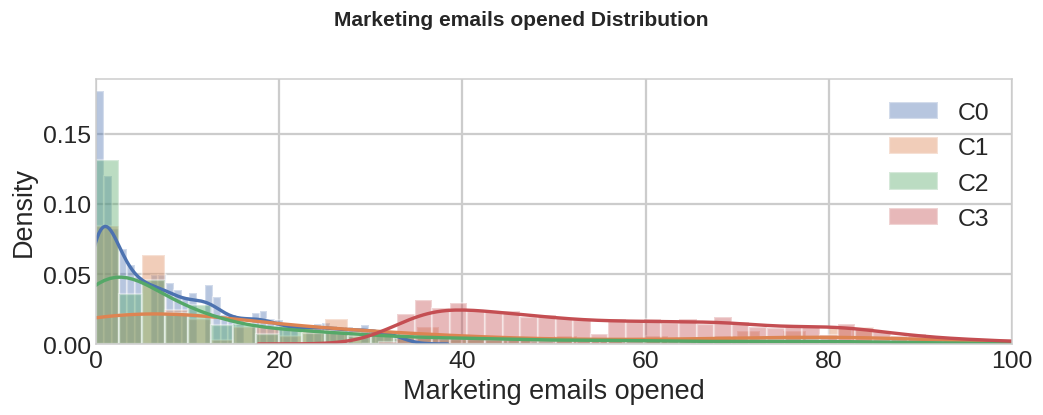

In [ ]:
plot_dists('Marketing emails opened',bins=40,xlim=100)

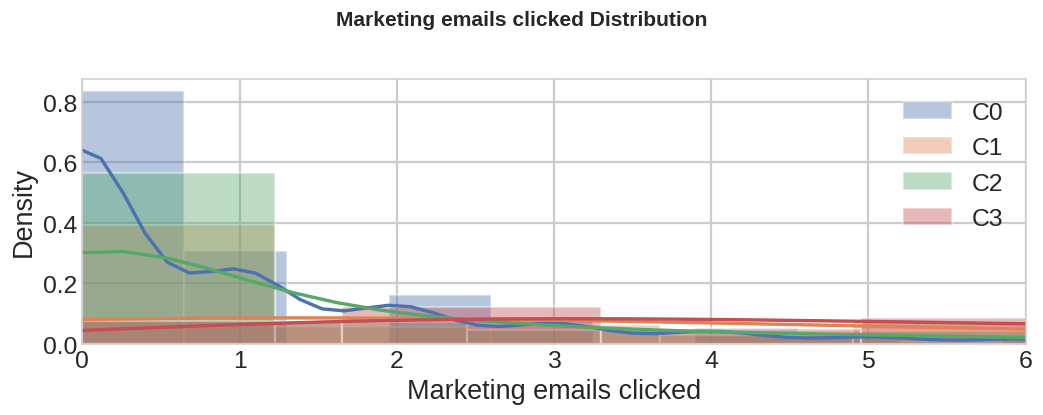

In [ ]:
plot_dists('Marketing emails clicked',bins=40,xlim=6)

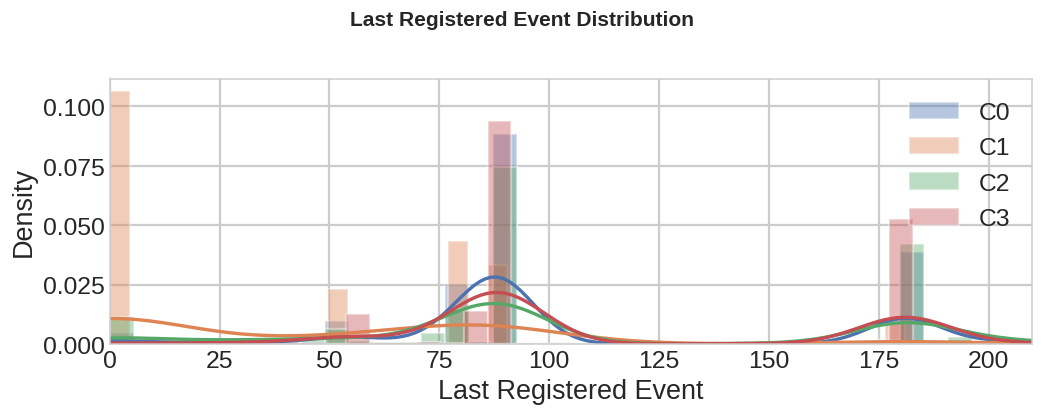

In [ ]:
plot_dists('Last Registered Event',bins=40,xlim=210)

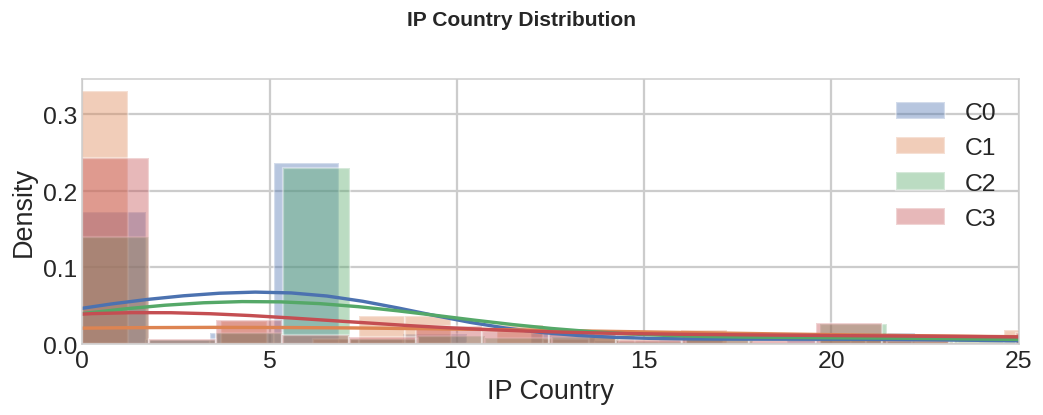

In [ ]:
plot_dists('IP Country',bins=100,xlim=25)

In [ ]:
topn=2
C0_countries = C0.groupby(C0['IP Country'])['IP Country'].count()
arg = np.flip(C0_countries.argsort().to_numpy())
C0_top_countries = Top(Countries_Dict,topn,arg)
C1_countries = C1.groupby(C1['IP Country'])['IP Country'].count()
arg = np.flip(C1_countries.argsort().to_numpy())
C1_top_countries = Top(Countries_Dict,topn,arg)
C2_countries = C2.groupby(C2['IP Country'])['IP Country'].count()
arg = np.flip(C2_countries.argsort().to_numpy())
C2_top_countries = Top(Countries_Dict,topn,arg)
C3_countries = C3.groupby(C3['IP Country'])['IP Country'].count()
arg = np.flip(C3_countries.argsort().to_numpy())
C3_top_countries = Top(Countries_Dict,topn,arg)

In [ ]:
Countries_Dict = Inv_Dict(Countries_Dict)

6

In [ ]:
fig = plt.figure(tight_layout=True, figsize=(10,4), dpi=108)
t = "Cluster 0 - Top Countries of Origin "
names = [c.title() for c in C0_top_countries]
data = C0_countries[0:topn+1]
myexplode = [0, 0.1, 0.3]
plt.suptitle(t, fontsize=12, fontweight='bold')
plt.pie(data, labels=names, startangle = 90, autopct='%1.2f%%', explode=myexplode, shadow=True, textprops={'fontsize': 10})
plt.show() 

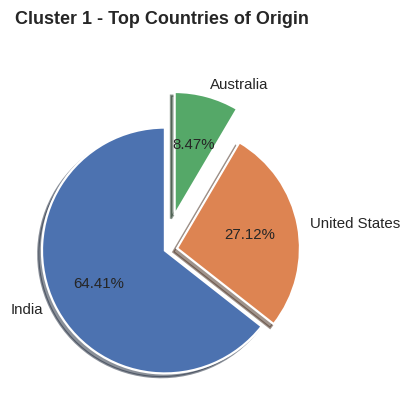

In [ ]:
fig = plt.figure(tight_layout=True, figsize=(10,4), dpi=108)
t = "Cluster 1 - Top Countries of Origin "
names = [c.title() for c in C1_top_countries]
data = C1_countries[0:topn+1]
myexplode = [0, 0.1, 0.3]
plt.suptitle(t, fontsize=12, fontweight='bold')
plt.pie(data, labels=names, startangle = 90, autopct='%1.2f%%', explode=myexplode, shadow=True, textprops={'fontsize': 10})
plt.show()

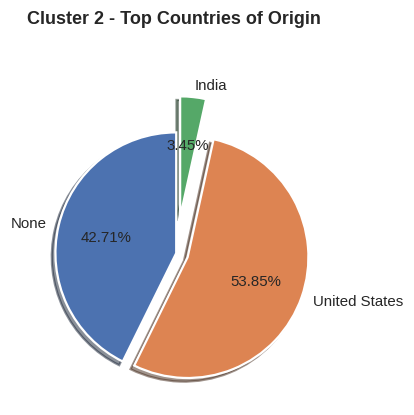

In [ ]:
fig = plt.figure(tight_layout=True, figsize=(10,4), dpi=108)
t = "Cluster 2 - Top Countries of Origin "
names = [c.title() for c in C2_top_countries]
data = C2_countries[0:topn+1]
myexplode = [0, 0.1, 0.3]
plt.suptitle(t, fontsize=12, fontweight='bold')
plt.pie(data, labels=names, startangle = 90, autopct='%1.2f%%', explode=myexplode, shadow=True, textprops={'fontsize': 10})
plt.show()

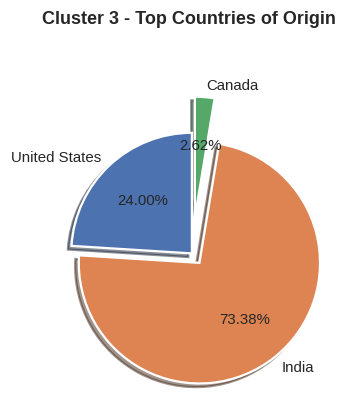

In [ ]:
fig = plt.figure(tight_layout=True, figsize=(10,4), dpi=108)
t = "Cluster 3 - Top Countries of Origin "
names = [c.title() for c in C3_top_countries]
data = C3_countries[0:topn+1]
myexplode = [0, 0.1, 0.3]
plt.suptitle(t, fontsize=12, fontweight='bold')
plt.pie(data, labels=names, startangle = 90, autopct='%1.2f%%', explode=myexplode, shadow=True, textprops={'fontsize': 10})
plt.show()

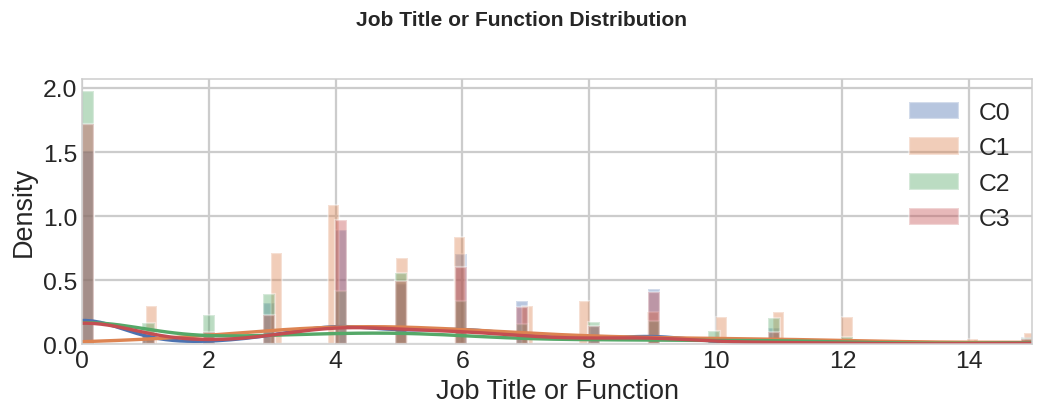

In [ ]:
plot_dists('Job Title or Function',bins=100,xlim=15)

In [ ]:
Jobs_Dict = Inv_Dict(Jobs_Dict)

In [ ]:
topn=2
C0_top_jobs, C0_top_names,C1_top_jobs, C1_top_names, C2_top_jobs, C2_top_names, C3_top_jobs, C3_top_names = Top_Clusters('Job Title or Function', Jobs_Dict, topn=2)

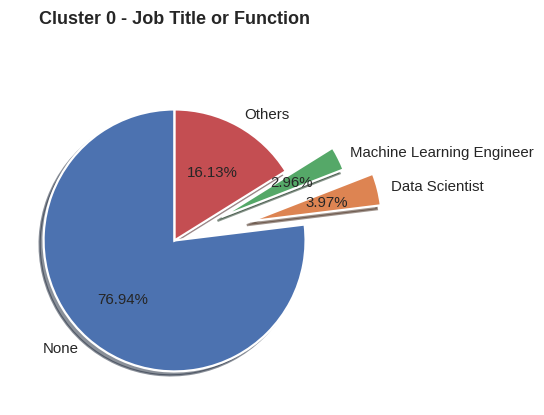

In [ ]:
Plot_Pie('Job Title or Function',0, C0_top_jobs, C0_top_names, topn, myexplode=[0,0.6,0.4,0])

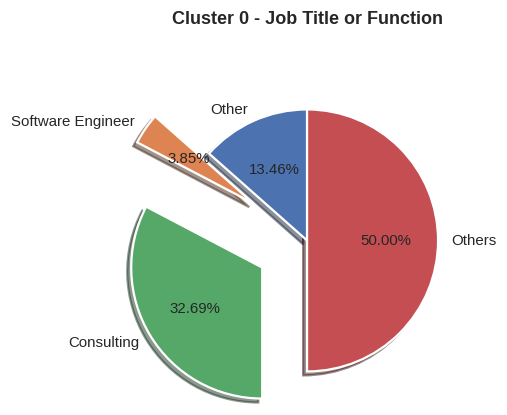

In [ ]:
Plot_Pie('Job Title or Function',0, C1_top_jobs, C1_top_names, topn, myexplode=[0,0.5,0.4,0])

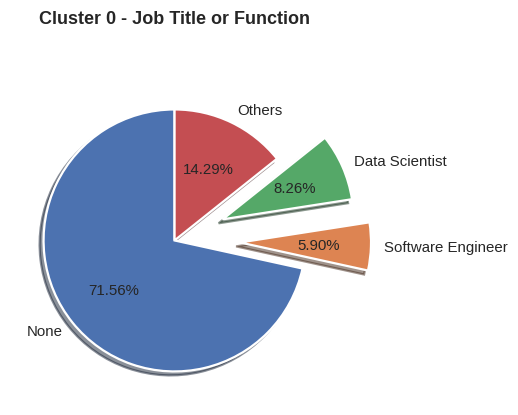

In [ ]:
Plot_Pie('Job Title or Function',0, C2_top_jobs, C2_top_names, topn, myexplode=[0,0.5,0.4,0])

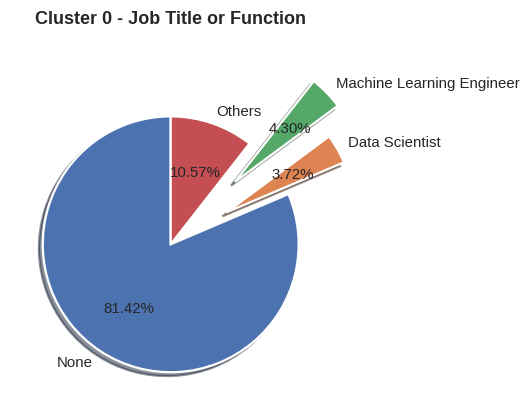

In [ ]:
Plot_Pie('Job Title or Function',0, C3_top_jobs, C3_top_names, topn, myexplode=[0,0.5,0.7,0])

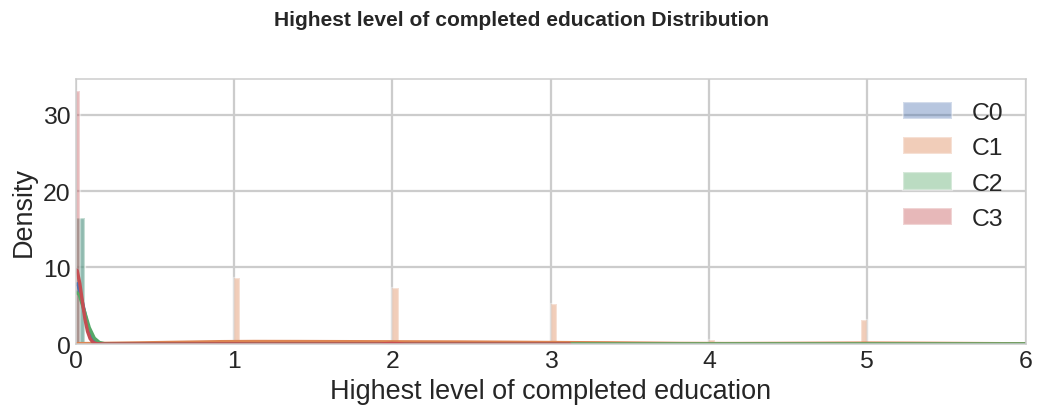

In [ ]:
plot_dists('Highest level of completed education',bins=100,xlim=6)

In [ ]:
Education_Dict = Inv_Dict(Education_Dict)

In [ ]:
opn=2
C0_ed, C0_top_ed,C1_ed, C1_top_ed,C2_ed, C2_top_ed,C3_ed, C3_top_ed = Top_Clusters('Highest level of completed education', Jobs_Dict, topn=2)

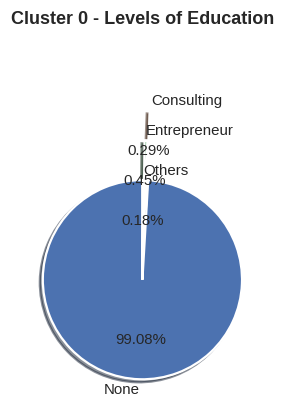

In [ ]:
Plot_Pie('Levels of Education',0, C0_ed, C0_top_ed, topn, myexplode=[0, 0.7, 0.4,0])

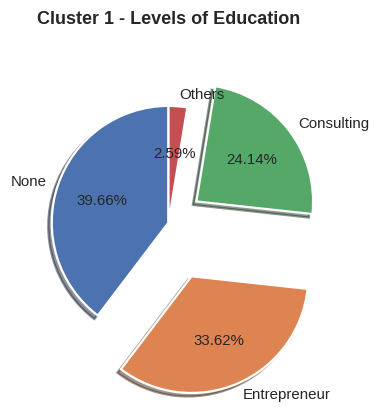

In [ ]:
Plot_Pie('Levels of Education',1, C1_ed, C1_top_ed, topn, myexplode=[0, 0.5, 0.3,0])

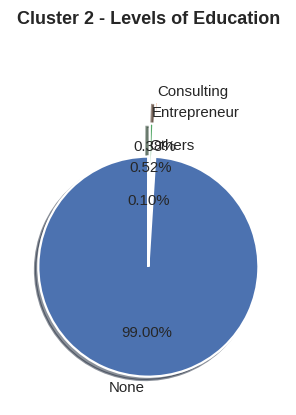

In [ ]:
Plot_Pie('Levels of Education',2, C2_ed, C2_top_ed, topn, myexplode=[0, 0.5, 0.3,0])

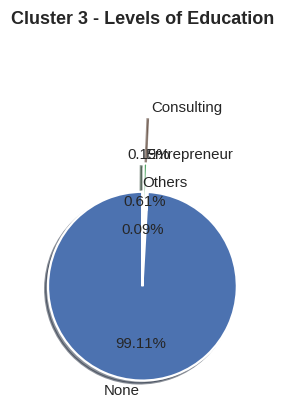

In [ ]:
Plot_Pie('Levels of Education',3, C3_ed, C3_top_ed, topn, myexplode=[0, 0.8, 0.3,0])

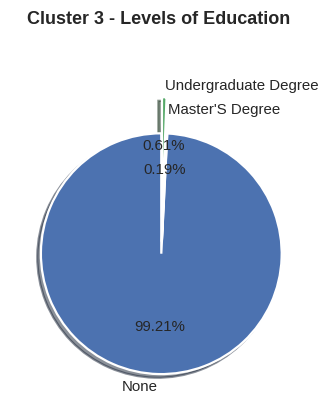

In [ ]:
fig = plt.figure(tight_layout=True, figsize=(10,4), dpi=108)
t = "Cluster 3 - Levels of Education "
names = [c.title() for c in C3_top_ed]
data = C3_ed[0:topn+1]
myexplode = [0, 0.1, 0.3]
plt.suptitle(t, fontsize=12, fontweight='bold')
plt.pie(data, labels=names, startangle = 90, autopct='%1.2f%%', explode=myexplode, shadow=True, textprops={'fontsize': 10})
plt.show()

In [ ]:
Events_Dict = Inv_Dict(Events_Dict)

In [ ]:
topn=2
C0_top_evs, C0_top_evs_names,C1_top_evs, C1_top_evs_names, C2_top_evs, C2_top_evs_names, C3_top_evs, C3_top_evs_names = Top_Clusters('Last Registered Event', Events_Dict, topn=2)

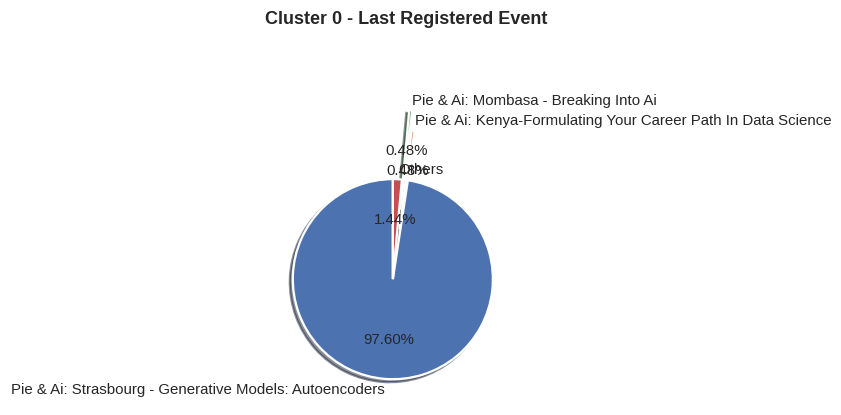

In [ ]:
Plot_Pie('Last Registered Event',0, C0_top_evs, C0_top_evs_names, topn, myexplode=[0,0.5,0.7,0])

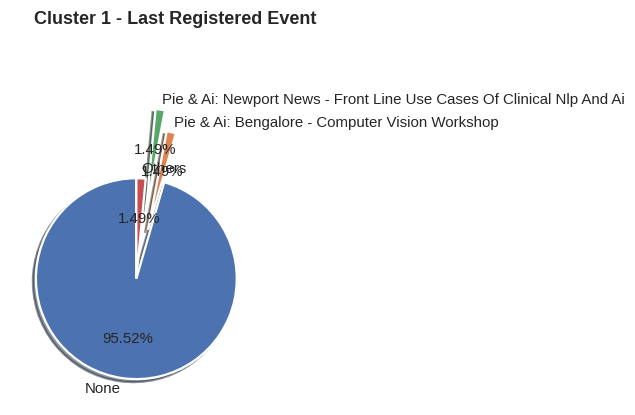

In [ ]:
Plot_Pie('Last Registered Event',1, C1_top_evs, C1_top_evs_names, topn, myexplode=[0,0.5,0.7,0])

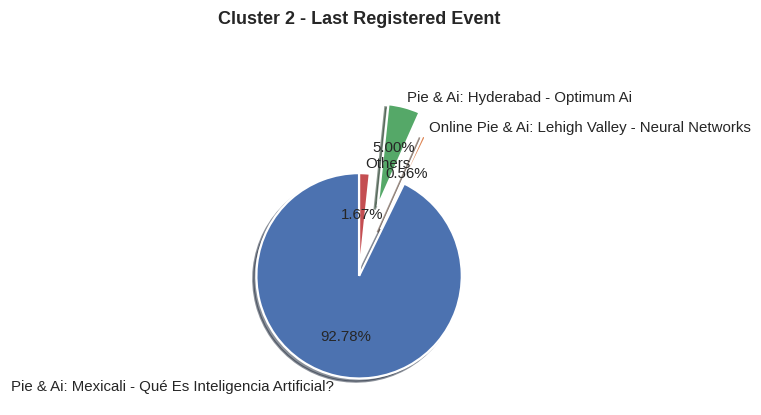

In [ ]:
Plot_Pie('Last Registered Event',2, C2_top_evs, C2_top_evs_names, topn, myexplode=[0,0.5,0.7,0])

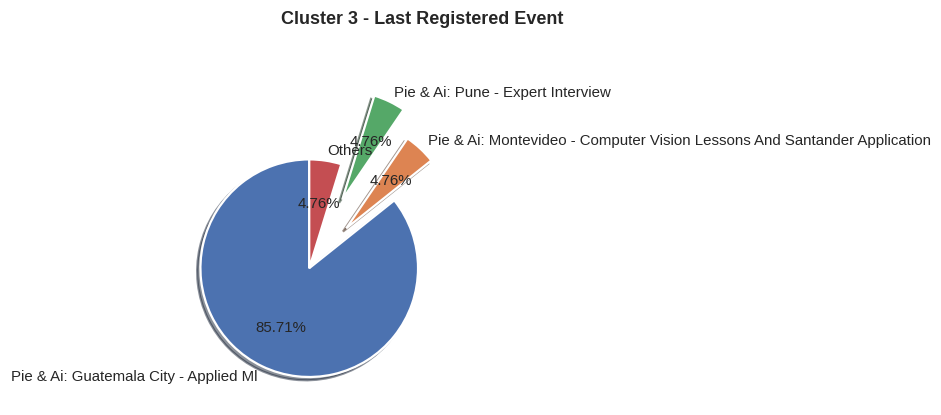

In [ ]:
Plot_Pie('Last Registered Event',3, C3_top_evs, C3_top_evs_names, topn, myexplode=[0,0.5,0.7,0])

In [ ]:
C0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7989 entries, 2 to 13179
Data columns (total 24 columns):
 #   Column                                          Non-Null Count  Dtype
---  ------                                          --------------  -----
 0   Last marketing email name                       7989 non-null   int64
 1   Average Pageviews                               7989 non-null   int64
 2   Number of Pageviews                             7989 non-null   int64
 3   Marketing emails opened                         7989 non-null   int64
 4   Marketing emails clicked                        7989 non-null   int64
 5   Opted out of email: Events and Community        7989 non-null   int64
 6   Opted out of email: Program Announcements       7989 non-null   int64
 7   Opted out of email: The Batch                   7989 non-null   int64
 8   Unsubscribed from all email                     7989 non-null   int64
 9   Last Registered Event                           7989 non-null 

In [ ]:
Courses_Dict

{'AI For Everyone': 0,
 'Deep Learning Specialization': 1,
 'Natural Language Processing Specialization': 2,
 'AI for Medicine Specialization': 3,
 'TensorFlow Developer Professional Certificate': 4,
 'TensorFlow: Data and Deployment Specialization': 5}

In [30]:
CT=np.zeros((4,7))
for k,v in Courses_Dict.items():
        CT[0,v]= C0[k].sum()/C0.shape[0]
        CT[1,v]= C1[k].sum()/C1.shape[0]
        CT[2,v]= C2[k].sum()/C2.shape[0]
        CT[3,v]= C3[k].sum()/C3.shape[0]
CT[0,6]=C0['Total Education Effort'].sum()/C0.shape[0]
CT[1,6]=C1['Total Education Effort'].sum()/C1.shape[0]
CT[2,6]=C2['Total Education Effort'].sum()/C2.shape[0]
CT[3,6]=C3['Total Education Effort'].sum()/C3.shape[0]
CT[0:5,0:6]=CT[0:5,0:6]*100

In [34]:
CT.astype(int)

array([[  0,  99,   0,   0,   0,   0,  80],
       [ 19,  96,  55,  48,  63,  24, 235],
       [100,   0,   0,   0,   0,   0,   6],
       [  0,  99,   0,   0,   0,   0,  80]])

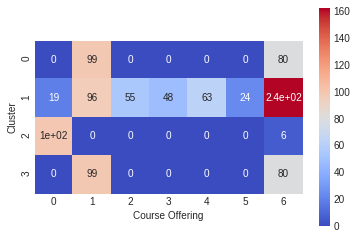

In [33]:
midpoint=(np.max(CT)-np.min(CT))
sns.heatmap(CT.astype(int),cmap='coolwarm',robust=True,square=True,annot=True)
plt.xlabel('Course Offering')
plt.ylabel('Cluster')
plt.show()